In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 

import pandas as pd
import numpy as np
import os
import csv

In [2]:
from keras.models import Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, Bidirectional, TimeDistributed

from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model


Using TensorFlow backend.


In [3]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [4]:
def read_preprocess_dataset(path):
    with open(path) as f:
        reader = csv.reader(f, delimiter="\t")
        d = list(reader)

    # find sentence breaks in txt file
    seperator_ind = []

    seperator_ind.append(-1)

    for idx,elem in enumerate(d):
        if len(elem) < 2:
            seperator_ind.append(idx)
        else:
            continue
    
    # create dataset which has 2 columns; sentences with word order, their corresponding tags
    sentences = []
    tags  = []


    for i in range(len(seperator_ind)-1):
        start_idx = seperator_ind[i]+1
        end_idx = seperator_ind[i+1]

        single_sentence = []
        single_sentence_tags = []

        # read word within start and end indices
        for j in range(start_idx,end_idx,1):
            single_sentence.append(d[j][1])
            single_sentence_tags.append(d[j][0])

        sentences.append(single_sentence)
        tags.append(single_sentence_tags)
        
    # initialize list of lists   
    data = [sentences,tags]

    # Create the pandas DataFrame 
    dataset = pd.DataFrame(data) 
    
    # transposed since i used to work with sentence-tag with row by row
    dataset = dataset.T
    
    print("Shape of dataset:", dataset.shape)
    print("Head of dataset:",dataset.head())
    
    print("Sample element words:",dataset.iloc[1547][0])
    print("Sample element tags:",dataset.iloc[1547][1])
    
    return dataset

In [5]:
dataset = read_preprocess_dataset("train.txt")

Shape of dataset: (9775, 2)
Head of dataset:                                                    0  \
0                [what, movies, star, bruce, willis]   
1  [show, me, films, with, drew, barrymore, from,...   
2  [what, movies, starred, both, al, pacino, and,...   
3  [find, me, all, of, the, movies, that, starred...   
4  [find, me, a, movie, with, a, quote, about, ba...   

                                                   1  
0                        [O, O, O, B-ACTOR, I-ACTOR]  
1       [O, O, O, O, B-ACTOR, I-ACTOR, O, O, B-YEAR]  
2  [O, O, O, O, B-ACTOR, I-ACTOR, O, B-ACTOR, I-A...  
3  [O, O, O, O, O, O, O, O, B-ACTOR, I-ACTOR, O, ...  
4                  [O, O, O, O, O, O, O, O, O, O, O]  
Sample element words: ['what', 'movie', 'featured', 'the', 'quote', 'i', 'see', 'dead', 'people']
Sample element tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [6]:
def get_unique_words(dataset):
    # unique words
    words = set()
    tags = set()


    [words.add(elem) for idx,d_elem in dataset.iterrows() for elem in d_elem[0] ];
    words.add("ENDPAD")
    words = list(words)

    [tags.add(elem) for idx,d_elem in dataset.iterrows() for elem in d_elem[1] ];
    tags.add(np.nan)
    tags = list(tags)
    
    return words,tags

In [7]:
words, tags = get_unique_words(dataset)
tags

[nan,
 'B-ACTOR',
 'I-TRAILER',
 'O',
 'I-SONG',
 'I-REVIEW',
 'I-YEAR',
 'B-DIRECTOR',
 'B-GENRE',
 'B-CHARACTER',
 'I-RATING',
 'I-DIRECTOR',
 'B-REVIEW',
 'B-SONG',
 'B-RATINGS_AVERAGE',
 'B-TRAILER',
 'I-PLOT',
 'B-TITLE',
 'I-GENRE',
 'B-PLOT',
 'B-RATING',
 'I-ACTOR',
 'I-CHARACTER',
 'B-YEAR',
 'I-TITLE',
 'I-RATINGS_AVERAGE']

In [8]:
len(words)

6711

In [9]:
"ENDPAD" in words

True

In [10]:
def convert_str_to_numerical(dataset, words,tags):
    word2idx = {words[i] : i for i in range(len(words))}
    tag2idx = {tags[i] : i for i in range(len(tags))}
    
    # Convert sentence to numerical
    X = [[word2idx[w] for w in d_elem[0]] for idx,d_elem in dataset.iterrows() ]
    y = [[tag2idx[t] for t in d_elem[1]] for idx,d_elem in dataset.iterrows()]
    
    return word2idx, tag2idx, X, y

In [11]:
def convert_str_to_numerical_test(dataset, word2idx, tag2idx):
    # Convert sentence to numerical
    X  =[]
    
    for idx,d_elem in dataset.iterrows():
        seq = []
        for w in d_elem[0]:
            try:
                num = word2idx[w]
            except:
                num = word2idx["ENDPAD"]
            finally:
                seq.append(num)
        X.append(seq)
    
    #X = [[word2idx[w] for w in d_elem[0]] for idx,d_elem in dataset.iterrows() ]
    y = [[tag2idx[t] for t in d_elem[1]] for idx,d_elem in dataset.iterrows()]
    
    return X, y

In [12]:
word2idx, tag2idx, X,y = convert_str_to_numerical(dataset, words,tags)

In [13]:
word2idx["ENDPAD"]

2835

In [14]:
tag2idx["O"]

3

In [15]:
tag2idx

{nan: 0,
 'B-ACTOR': 1,
 'I-TRAILER': 2,
 'O': 3,
 'I-SONG': 4,
 'I-REVIEW': 5,
 'I-YEAR': 6,
 'B-DIRECTOR': 7,
 'B-GENRE': 8,
 'B-CHARACTER': 9,
 'I-RATING': 10,
 'I-DIRECTOR': 11,
 'B-REVIEW': 12,
 'B-SONG': 13,
 'B-RATINGS_AVERAGE': 14,
 'B-TRAILER': 15,
 'I-PLOT': 16,
 'B-TITLE': 17,
 'I-GENRE': 18,
 'B-PLOT': 19,
 'B-RATING': 20,
 'I-ACTOR': 21,
 'I-CHARACTER': 22,
 'B-YEAR': 23,
 'I-TITLE': 24,
 'I-RATINGS_AVERAGE': 25}

In [16]:
max_seq_length = 0
for x in X:
    if len(x) > max_seq_length:
        max_seq_length = len(x)    

In [17]:
max_seq_length

47

In [18]:
X = pad_sequences(maxlen=max_seq_length, sequences=X, padding='post', value=word2idx["ENDPAD"])
y = pad_sequences(maxlen=max_seq_length, sequences=y, padding='post', value=tag2idx["O"])

In [19]:
X.shape

(9775, 47)

In [20]:
y.shape

(9775, 47)

In [21]:
y[0]

array([ 3,  3,  3,  1, 21,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3])

In [22]:
# One-hot Encoding
y = to_categorical(y, num_classes=len(tag2idx))

In [23]:
y.shape

(9775, 47, 26)

In [24]:
# Early Stopping Callback
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint(filepath='best_model_NER.h5', monitor='val_loss', save_best_only=True)]

In [25]:
# Build Model
from keras.models import Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Input

input_node = Input(shape=(max_seq_length,))
embedding = Embedding(input_dim=len(words), output_dim=100, input_length=max_seq_length)(input_node)
rec_layer = Bidirectional(LSTM(50, return_sequences= True, recurrent_dropout=0.2))(embedding)
output = TimeDistributed(Dense(len(tag2idx), activation="softmax"))(rec_layer)

NER = Model(input_node, output)

In [26]:
NER.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [27]:
NER.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 47)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 47, 100)           671100    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 47, 100)           60400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 47, 26)            2626      
Total params: 734,126
Trainable params: 734,126
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = NER.fit(X, np.array(y), batch_size=32, epochs=20, validation_split=0.3,callbacks=callbacks, verbose=1)

C:\Users\dtecitak\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 6842 samples, validate on 2933 samples
Epoch 1/20
6842/6842 [==============================] - 10s 2ms/step - loss: 0.5957 - accuracy: 0.9125 - val_loss: 0.3582 - val_accuracy: 0.9082
Epoch 2/20
6842/6842 [==============================] - 11s 2ms/step - loss: 0.2689 - accuracy: 0.9298 - val_loss: 0.2400 - val_accuracy: 0.9400
Epoch 3/20
6842/6842 [==============================] - 10s 2ms/step - loss: 0.1883 - accuracy: 0.9549 - val_loss: 0.1491 - val_accuracy: 0.9607
Epoch 4/20
6842/6842 [==============================] - 10s 1ms/step - loss: 0.1252 - accuracy: 0.9706 - val_loss: 0.1005 - val_accuracy: 0.9761
Epoch 5/20
6842/6842 [==============================] - 10s 1ms/step - loss: 0.0915 - accuracy: 0.9779 - val_loss: 0.0844 - val_accuracy: 0.9784
Epoch 6/20
6842/6842 [==============================] - 10s 1ms/step - loss: 0.0740 - accuracy: 0.9817 - val_loss: 0.0749 - val_accuracy: 0.9791
Epoch 7/20
6842/6842 [==============================] - 10s 1ms/step - loss: 0.062

In [29]:
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


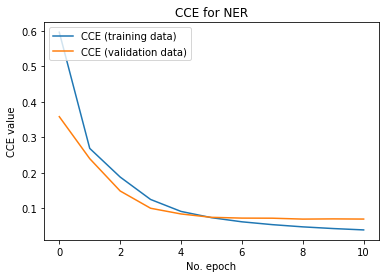

In [30]:
# Plot history: Categorical CrossEntropy(CCE)
plt.plot(history.history['loss'], label='CCE (training data)')
plt.plot(history.history['val_loss'], label='CCE (validation data)')

plt.title('CCE for NER')
plt.ylabel('CCE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

plt.show()

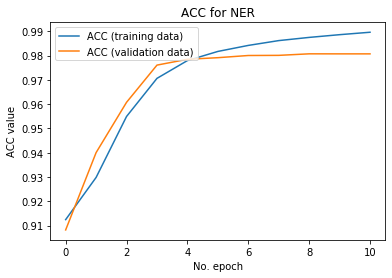

In [31]:
# Plot history: Accuracy(CCE)
plt.plot(history.history['accuracy'], label='ACC (training data)')
plt.plot(history.history['val_accuracy'], label='ACC (validation data)')

plt.title('ACC for NER')
plt.ylabel('ACC value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

plt.show()

In [32]:
test_set = read_preprocess_dataset("test.txt")

Shape of dataset: (2443, 2)
Head of dataset:                                                    0  \
0  [are, there, any, good, romantic, comedies, ou...   
1      [show, me, a, movie, about, cars, that, talk]   
2  [list, the, five, star, rated, movies, starrin...   
3  [what, science, fiction, films, have, come, ou...   
4  [did, the, same, director, make, all, of, the,...   

                                                   1  
0  [O, O, O, O, B-GENRE, I-GENRE, O, B-YEAR, I-YEAR]  
1            [O, O, O, O, O, B-PLOT, I-PLOT, I-PLOT]  
2  [O, O, B-RATINGS_AVERAGE, I-RATINGS_AVERAGE, O...  
3          [O, B-GENRE, I-GENRE, O, O, O, O, B-YEAR]  
4      [O, O, O, O, O, O, O, O, B-TITLE, I-TITLE, O]  
Sample element words: ['is', 'there', 'an', 'r', 'rated', 'fantasy', 'directed', 'by', 'robert', 'taylor', 'that', 'is', 'liked', 'by', 'many']
Sample element tags: ['O', 'O', 'O', 'B-RATING', 'O', 'B-GENRE', 'O', 'O', 'B-DIRECTOR', 'I-DIRECTOR', 'O', 'O', 'B-RATINGS_AVERAGE', 'I-RATINGS

In [33]:
words, tags = get_unique_words(test_set)

In [34]:
X,y = convert_str_to_numerical_test(test_set, word2idx, tag2idx)

In [35]:
#max_seq_lengthx_sequence_length  is same also for test set, since lstm is trained with it previously

In [36]:
X = pad_sequences(maxlen=max_seq_length, sequences=X, padding='post', value=word2idx["ENDPAD"])
y = pad_sequences(maxlen=max_seq_length, sequences=y, padding='post', value=tag2idx["O"])

In [37]:
# One-hot Encoding
y = to_categorical(y, num_classes=len(tag2idx))

In [38]:
# Load Best Model
best_model = load_model("best_model_NER.h5")

C:\Users\dtecitak\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [39]:
score, acc = NER.evaluate(X,y)

2443/2443 [==============================] - 1s 400us/step


In [40]:
print("Test Set Acc:",acc)

Test Set Acc: 0.973767876625061


In [41]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("ENDPAD", "O"))
        out.append(out_i)
    return out

In [42]:
test_pred = NER.predict(X)

In [43]:
idx2tag = dict(map(reversed, tag2idx.items()))

In [44]:
pred_labels = pred2label(test_pred)
test_labels = pred2label(y)

In [45]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 72.4%
